In [4]:
import numpy as np
import pandas as pd 

In [5]:
# 引入工程所需要的库
from pyecharts import online
online() # 使用远程 jshost

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

# 1. 数据总览

## 1.1 加载数据

In [7]:
# 原始数据路径
train_path = 'H://train_data.csv'
importance_feature_path = 'H://importance_feature_data.csv'
columns = pd.read_csv(importance_feature_path)

# 读取原始数据
# train_data-final数据
train_data = pd.read_csv(train_path)
train_data = train_data[list(columns['importance_feature'].values)+['hand']]

In [8]:
train_data.shape

(29710, 44)

观察前几行的源数据：

In [9]:
train_data.head()

,rankCount1,rankCount2,rankCount3,suitCount3,suitCount2,suitCount1,suitCount4,diff8_3,rankCount4,diff9_3,...,rank5,diff4_2,diff11_5,diff11_2,rank12,diff5_4,diff4_3,diff12_11,diff12_1,hand
0,5,0,0,5,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
1,5,0,0,0,0,0,5,0,0,0,...,0,0,1,1,1,0,0,0,0,1
2,5,0,0,0,5,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
3,5,0,0,0,0,5,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
4,5,0,0,0,0,5,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1


数据信息总览：

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29710 entries, 0 to 29709
Data columns (total 44 columns):
rankCount1    29710 non-null int64
rankCount2    29710 non-null int64
rankCount3    29710 non-null int64
suitCount3    29710 non-null int64
suitCount2    29710 non-null int64
suitCount1    29710 non-null int64
suitCount4    29710 non-null int64
diff8_3       29710 non-null int64
rankCount4    29710 non-null int64
diff9_3       29710 non-null int64
diff9_4       29710 non-null int64
diff9_2       29710 non-null int64
diff10_5      29710 non-null int64
diff9_8       29710 non-null int64
diff10_9      29710 non-null int64
diff8_4       29710 non-null int64
diff11_3      29710 non-null int64
diff8_2       29710 non-null int64
diff3_1       29710 non-null int64
diff3_2       29710 non-null int64
diff7_1       29710 non-null int64
diff13_8      29710 non-null int64
diff12_7      29710 non-null int64
diff11_6      29710 non-null int64
diff7_2       29710 non-null int64
diff6_1       29

In [11]:
X = train_data.drop(['hand'],axis=1)
y = train_data.hand


# 2. 基学习器的对比

构建不同的基学习器，这里我们使用了RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM七个基学习器：（这里的模型可以使用如上面的GridSearch方法对模型的超参数进行搜索选择

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

models = {}


mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 15), solver='adam', activation='tanh', alpha = 0.0001, learning_rate_init=0.001, max_iter=400)
models['mlp'] = mlp
rf = RandomForestClassifier(max_depth=32,min_samples_split=3,min_samples_leaf=2,verbose=0)
models['rf'] = rf
# ada = AdaBoostClassifier(n_estimators=500,learning_rate=0.1)
# models['ada'] = ada
et = ExtraTreesClassifier(n_estimators=150,max_depth=15,min_samples_leaf=2,verbose=0)
models['et'] = et
gb = GradientBoostingClassifier(n_estimators=270,verbose=0)
models['gb'] = gb
dt = DecisionTreeClassifier(max_depth=17)
models['dt'] = dt
knn = KNeighborsClassifier(n_neighbors=1)
models['knn'] = knn
svm = SVC(kernel='rbf', gamma=0.1, C=1)
models['svm'] = svm


In [10]:
from sklearn.model_selection import cross_val_score
import time

all_model_avg_score = {}
all_model_time = {}

for key, model in models.iteritems():
    begin_time = time.time()
    scores = cross_val_score(model, X, y,cv=3)
    end_time = time.time()
    all_model_avg_score[key] = round(scores.mean()*100, 4)
    all_model_time[key] = round((end_time-begin_time)/3, 4)

## 2.1 预测效果得分对比

In [11]:
#预测得分对比图
from pyecharts import Bar

attr = all_model_avg_score.keys()
v = all_model_avg_score.values()
bar = Bar("预测得分对比图")
bar.add("训练集", attr, v, is_label_show=True, is_more_utils=True)
bar

# 2.2 预测时间对比

In [12]:
#预测时间对比图
from pyecharts import Bar

attr = all_model_time.keys()
v = all_model_time.values()
bar = Bar("预测时间对比图")
bar.add("训练集", attr, v, is_label_show=True, is_more_utils=True)
bar

# 3. 验证：各个基学习器的学习曲线

在我们对数据不断地进行特征工程，产生的特征越来越多，用大量的特征对模型进行训练，会使我们的训练集拟合得越来越好，但同时也可能会逐渐丧失泛化能力，从而在测试数据上表现不佳，发生过拟合现象。

当然我们建立的模型可能不仅在预测集上表现不好，也很可能是因为在训练集上的表现不佳，处于欠拟合状态。

下图是机器学习中的四种学习曲线：

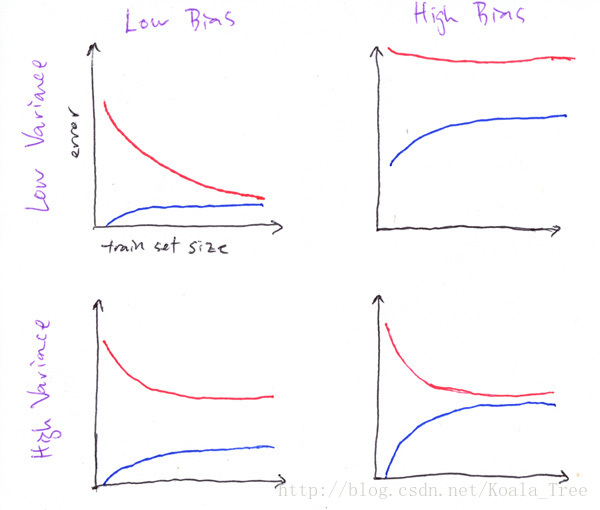

In [2]:
from IPython.display import Image
Image(filename='Image/wnd.jpg')

上面红线代表test error（Cross-validation error），蓝线代表train error。这里我们也可以把错误率替换为准确率，那么相应曲线的走向就应该是上下颠倒的，（score=1-error）。

注意我们的图中是error曲线。

   1.左上角是最优情况，随着样本数的增加，train error虽然有一定的增加，但是test error却有很明显的降低；

   2.右上角是最差情况，train error很大，模型并没有从特征 中学习到什么，导致test error非常大，模型几乎无法预测数据，需要去寻找数据本身和训练阶段的原因；

   3.左下角是high variance，train error虽然较低，但是模型产生了过拟合，缺乏泛化能力，导致test error很高；

   4.右下角是high bias的情况，train error很高，这时需要去调整模型的参数，减小train error。

所以我们通过学习曲线观察模型处于什么样的状态。从而决定对模型进行如何的操作。当然，我们把验证放到最后，并不是这一步在最后去做。对于我们的Stacking框架中第一层的各个基学习器我们都应该对其学习曲线进行观察，从而去更好地调节超参数，进而得到更好的最终结果。

构建绘制学习曲线的函数：

In [13]:
from sklearn.learning_curve import learning_curve
 
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,
                        n_jobs=1,train_sizes=np.linspace(.1,1.0,5),verbose=0):
    """
    Generate a simple plot of the test and training learning curve.
    
    Parameters
    -------------
    estimator:object type that implents the "fit" and "predict" methods
    An object of that type which is cloned for each validation.
    
    title:string
    Title for the chart.
    
    X:array-like,shape(n_samples,n_features)
    Training vector,where n_samples is the number of samples and n_features is 
    the number of features.
    
    y:array-like,shape(n_samples) or (n_samples,n_features),optional
    Target relative to X for classification or regression;
    None for unsupervised learning.
    
    ylim:tuple,shape(ymin,ymax),optional
    Defines minimum and maximum yvalues plotted.
    
    cv:integer,cross-validation generator,optional
    If an integer is passed,it is the number of folds(defaults to 3).
    Specific cross-validation objects can be passed,see
    sklearn.cross_validation module for the list of possible objects
    
    n_jobs:integer,optional
    Number of jobs to run in parallel(default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes,train_scores,test_scores = learning_curve(estimator,X,y,cv=cv,
                                                          n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color="r",label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color="g",label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

D:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda2\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [15]:
X = X
Y = y

#MLP
mlp_parameters = {'hidden_layer_sizes':(50, 50, 15), 'solver':'adam', 'activation':'tanh', 'alpha' : 0.0001, 'learning_rate_init':0.001, 'max_iter':400}
 
# RandomForest
rf_parameters = {'max_depth':32, 'min_samples_leaf':2,'min_samples_split':3, 'verbose':0}
 
# AdaBoost
#ada_parameters = {'n_estimators':500,'learning_rate':0.1}
 
# ExtraTrees
et_parameters = {'n_estimators':150,'max_depth':15,'min_samples_leaf':2,'verbose':0}
 
# GradientBoosting
gb_parameters = {'n_estimators':270,'verbose':0}
 
# DecisionTree
dt_parameters = {'max_depth':17}
 
# KNeighbors
knn_parameters = {'n_neighbors':1}
 
# SVM
svm_parameters = {'kernel':'rbf', 'gamma':0.1, 'C':1}


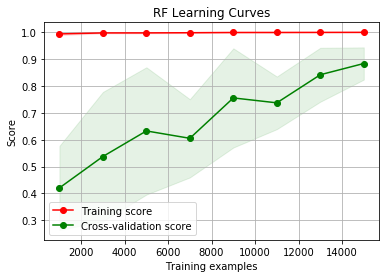

In [24]:
title = "RF Learning Curves"
plot_learning_curve(rf,title,X,Y,cv=None,n_jobs=4,
                    train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

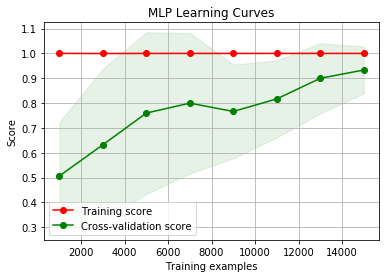

In [25]:
title = "MLP Learning Curves"
plot_learning_curve(mlp,title,X,Y,cv=None,n_jobs=4,
                    train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

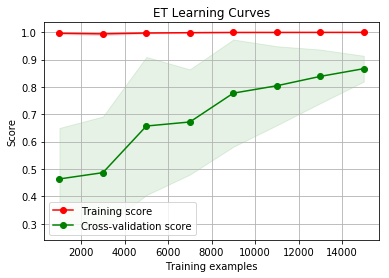

In [27]:
title = "ET Learning Curves"
plot_learning_curve(et,title,X,Y,cv=None,n_jobs=4,
                    train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

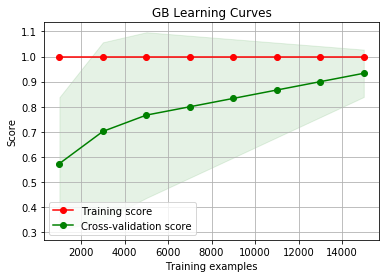

In [28]:
title = "GB Learning Curves"
plot_learning_curve(gb,title,X,Y,cv=None,n_jobs=4,
                     train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

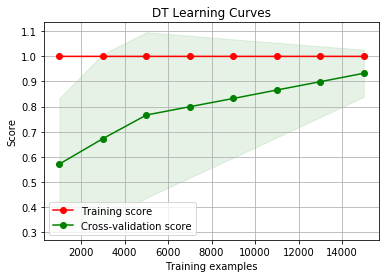

In [29]:
title = "DT Learning Curves"
plot_learning_curve(dt,title,X,Y,cv=None,n_jobs=4,
                    train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

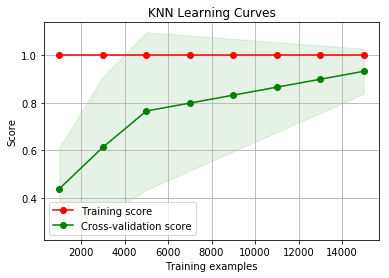

In [31]:
title = "KNN Learning Curves"
plot_learning_curve(knn,title,X,Y,cv=None,n_jobs=4,
                   train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

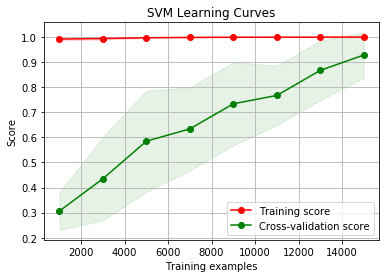

In [32]:
title = "SVM Learning Curves"
plot_learning_curve(svm,title,X,Y,cv=None,n_jobs=4,
                   train_sizes=[1000,3000,5000,7000,9000,11000, 13000, 15000])
plt.show()

分析：
   由上面的分析我们可以看出，对于RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM的模型，这里是存在一定的问题的，所以我们需要去调整模型的超参数，从而达到更好的效果。